## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #

import os
import requests
import zipfile

# Create a folder 'data/' in the current directory
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# URL of the file to be downloaded
url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip"
file_name = 'train-test-data.zip'

# Download the content into the 'data/' folder
response = requests.get(url)
with open(file_name, 'wb') as file:
    file.write(response.content)

downloaded_file_path = os.path.abspath(file_name)
print(f"File downloaded to {downloaded_file_path}")
print(f"File name: {file_name}")


# Unzip the file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(folder_name)

print(f"Files extracted to {os.path.abspath(folder_name)}")

File downloaded to /workspace/home/train-test-data.zip
File name: train-test-data.zip
Files extracted to /workspace/home/data


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np


# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
## TODO: Define the Net in models.py


## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

# Instantiate the network and move it to the device (GPU or CPU)
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, 

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform =  transforms.Compose([
    Rescale((250, 250)),
    RandomCrop((224, 224)),
    Normalize(),
    ToTensor()
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/workspace/data/training_frames_keypoints.csv',
                                             root_dir='/workspace/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/workspace/data/test_frames_keypoints.csv',
                                             root_dir='/workspace/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 8

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=15, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=15, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

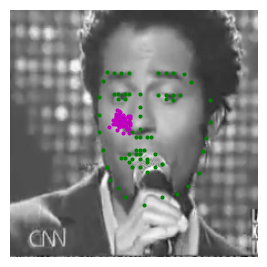

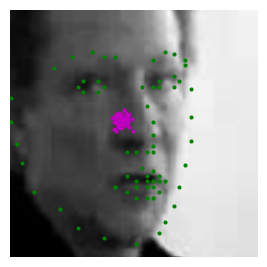

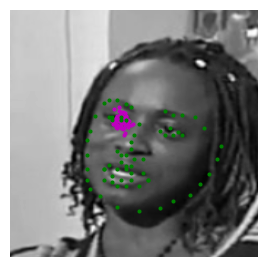

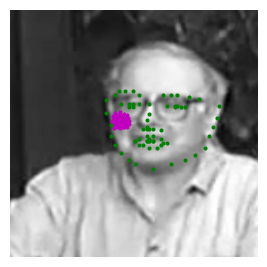

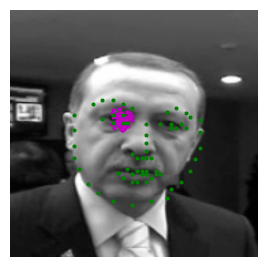

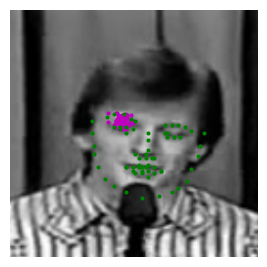

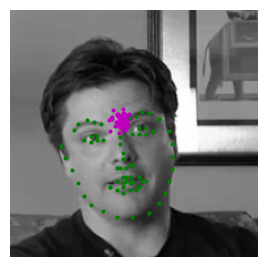

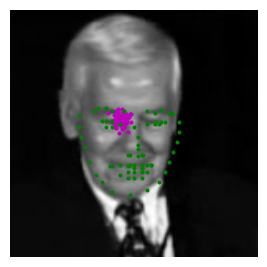

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=8):

    for i in range(batch_size):
        plt.figure(figsize=(30,10))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu()
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu()        
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image'].to(device)
            key_pts = data['keypoints'].to(device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 16 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.39604683220386505
Epoch: 1, Batch: 26, Avg. Loss: 0.5411810159683228
Epoch: 1, Batch: 42, Avg. Loss: 0.42310972660779955
Epoch: 1, Batch: 58, Avg. Loss: 0.361053965985775
Epoch: 1, Batch: 74, Avg. Loss: 0.3320325449109077
Epoch: 1, Batch: 90, Avg. Loss: 0.32417107075452806
Epoch: 1, Batch: 106, Avg. Loss: 0.27723024785518646
Epoch: 1, Batch: 122, Avg. Loss: 0.27967304140329363
Epoch: 1, Batch: 138, Avg. Loss: 0.25763092637062074
Epoch: 1, Batch: 154, Avg. Loss: 0.25855725780129435
Epoch: 1, Batch: 170, Avg. Loss: 0.236357581615448
Epoch: 1, Batch: 186, Avg. Loss: 0.23006488680839537
Epoch: 1, Batch: 202, Avg. Loss: 0.26965183913707735
Epoch: 1, Batch: 218, Avg. Loss: 0.23554623797535895
Epoch: 1, Batch: 234, Avg. Loss: 0.25042831525206566
Epoch: 1, Batch: 250, Avg. Loss: 0.22826978638768197
Epoch: 1, Batch: 266, Avg. Loss: 0.21648377925157547
Epoch: 1, Batch: 282, Avg. Loss: 0.253728860616684
Epoch: 1, Batch: 298, Avg. Loss: 0.23627030104398727
Epoch: 

Epoch: 6, Batch: 362, Avg. Loss: 0.15777246914803983
Epoch: 6, Batch: 378, Avg. Loss: 0.19205288589000702
Epoch: 6, Batch: 394, Avg. Loss: 0.15879959166049956
Epoch: 6, Batch: 410, Avg. Loss: 0.18825909234583377
Epoch: 6, Batch: 426, Avg. Loss: 0.19257108606398105
Epoch: 7, Batch: 10, Avg. Loss: 0.09978225082159042
Epoch: 7, Batch: 26, Avg. Loss: 0.14176231101155282
Epoch: 7, Batch: 42, Avg. Loss: 0.15910996310412884
Epoch: 7, Batch: 58, Avg. Loss: 0.14970071464776993
Epoch: 7, Batch: 74, Avg. Loss: 0.17014034315943719
Epoch: 7, Batch: 90, Avg. Loss: 0.17050567641854286
Epoch: 7, Batch: 106, Avg. Loss: 0.15665797516703606
Epoch: 7, Batch: 122, Avg. Loss: 0.17211206369102
Epoch: 7, Batch: 138, Avg. Loss: 0.16262449473142623
Epoch: 7, Batch: 154, Avg. Loss: 0.19596727862954139
Epoch: 7, Batch: 170, Avg. Loss: 0.17584105543792247
Epoch: 7, Batch: 186, Avg. Loss: 0.18153959400951863
Epoch: 7, Batch: 202, Avg. Loss: 0.17370648682117462
Epoch: 7, Batch: 218, Avg. Loss: 0.1641370017081499
Epo

Epoch: 12, Batch: 250, Avg. Loss: 0.14912353195250033
Epoch: 12, Batch: 266, Avg. Loss: 0.1529636986553669
Epoch: 12, Batch: 282, Avg. Loss: 0.16155039370059968
Epoch: 12, Batch: 298, Avg. Loss: 0.17401538491249086
Epoch: 12, Batch: 314, Avg. Loss: 0.1509501900523901
Epoch: 12, Batch: 330, Avg. Loss: 0.1763831742107868
Epoch: 12, Batch: 346, Avg. Loss: 0.17297228872776033
Epoch: 12, Batch: 362, Avg. Loss: 0.16198790743947028
Epoch: 12, Batch: 378, Avg. Loss: 0.1587354712188244
Epoch: 12, Batch: 394, Avg. Loss: 0.15327606052160264
Epoch: 12, Batch: 410, Avg. Loss: 0.16619432233273984
Epoch: 12, Batch: 426, Avg. Loss: 0.16070246510207653
Epoch: 13, Batch: 10, Avg. Loss: 0.0942128174006939
Epoch: 13, Batch: 26, Avg. Loss: 0.15189881026744842
Epoch: 13, Batch: 42, Avg. Loss: 0.16658538542687892
Epoch: 13, Batch: 58, Avg. Loss: 0.1445109874010086
Epoch: 13, Batch: 74, Avg. Loss: 0.16897409819066525
Epoch: 13, Batch: 90, Avg. Loss: 0.16151572316884993
Epoch: 13, Batch: 106, Avg. Loss: 0.1593

Epoch: 18, Batch: 330, Avg. Loss: 0.15635467059910296
Epoch: 18, Batch: 346, Avg. Loss: 0.1568880293518305
Epoch: 18, Batch: 362, Avg. Loss: 0.16505232751369475
Epoch: 18, Batch: 378, Avg. Loss: 0.13885914012789727
Epoch: 18, Batch: 394, Avg. Loss: 0.16573187857866287
Epoch: 18, Batch: 410, Avg. Loss: 0.19515526294708252
Epoch: 18, Batch: 426, Avg. Loss: 0.14344961158931255
Epoch: 19, Batch: 10, Avg. Loss: 0.08167596086859703
Epoch: 19, Batch: 26, Avg. Loss: 0.14330723881721497
Epoch: 19, Batch: 42, Avg. Loss: 0.15770818777382373
Epoch: 19, Batch: 58, Avg. Loss: 0.14796613827347754
Epoch: 19, Batch: 74, Avg. Loss: 0.17656897753477097
Epoch: 19, Batch: 90, Avg. Loss: 0.16585325188934802
Epoch: 19, Batch: 106, Avg. Loss: 0.14968851022422314
Epoch: 19, Batch: 122, Avg. Loss: 0.16455333381891252
Epoch: 19, Batch: 138, Avg. Loss: 0.18430439680814742
Epoch: 19, Batch: 154, Avg. Loss: 0.14145231246948242
Epoch: 19, Batch: 170, Avg. Loss: 0.17207126766443254
Epoch: 19, Batch: 186, Avg. Loss: 0

Epoch: 24, Batch: 202, Avg. Loss: 0.16208406426012517
Epoch: 24, Batch: 218, Avg. Loss: 0.15706727430224418
Epoch: 24, Batch: 234, Avg. Loss: 0.14193756096065044
Epoch: 24, Batch: 250, Avg. Loss: 0.1528226863592863
Epoch: 24, Batch: 266, Avg. Loss: 0.13988466635346414
Epoch: 24, Batch: 282, Avg. Loss: 0.15999446921050547
Epoch: 24, Batch: 298, Avg. Loss: 0.15604590363800525
Epoch: 24, Batch: 314, Avg. Loss: 0.14909022860229015
Epoch: 24, Batch: 330, Avg. Loss: 0.15510935038328172
Epoch: 24, Batch: 346, Avg. Loss: 0.16811264976859092
Epoch: 24, Batch: 362, Avg. Loss: 0.14056293703615666
Epoch: 24, Batch: 378, Avg. Loss: 0.1528031099587679
Epoch: 24, Batch: 394, Avg. Loss: 0.15870317332446576
Epoch: 24, Batch: 410, Avg. Loss: 0.16599143743515016
Epoch: 24, Batch: 426, Avg. Loss: 0.14567189589142798
Epoch: 25, Batch: 10, Avg. Loss: 0.11270143836736679
Epoch: 25, Batch: 26, Avg. Loss: 0.1419077582657337
Epoch: 25, Batch: 42, Avg. Loss: 0.16198207288980485
Epoch: 25, Batch: 58, Avg. Loss: 0

Epoch: 30, Batch: 74, Avg. Loss: 0.16796465553343295
Epoch: 30, Batch: 90, Avg. Loss: 0.1585899218916893
Epoch: 30, Batch: 106, Avg. Loss: 0.1654692828655243
Epoch: 30, Batch: 122, Avg. Loss: 0.1573469430208206
Epoch: 30, Batch: 138, Avg. Loss: 0.18714789003133775
Epoch: 30, Batch: 154, Avg. Loss: 0.18794747367501258
Epoch: 30, Batch: 170, Avg. Loss: 0.1691484920680523
Epoch: 30, Batch: 186, Avg. Loss: 0.1557912167161703
Epoch: 30, Batch: 202, Avg. Loss: 0.16673265770077705
Epoch: 30, Batch: 218, Avg. Loss: 0.14287875555455684
Epoch: 30, Batch: 234, Avg. Loss: 0.1636330582201481
Epoch: 30, Batch: 250, Avg. Loss: 0.1539182834327221
Epoch: 30, Batch: 266, Avg. Loss: 0.16299804113805294
Epoch: 30, Batch: 282, Avg. Loss: 0.1320735454559326
Epoch: 30, Batch: 298, Avg. Loss: 0.186993869766593
Epoch: 30, Batch: 314, Avg. Loss: 0.16600377224385737
Epoch: 30, Batch: 330, Avg. Loss: 0.1407928716391325
Epoch: 30, Batch: 346, Avg. Loss: 0.16445393227040767
Epoch: 30, Batch: 362, Avg. Loss: 0.15815

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


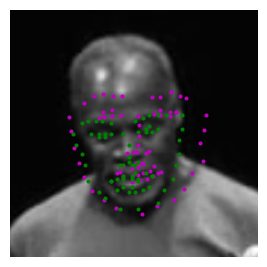

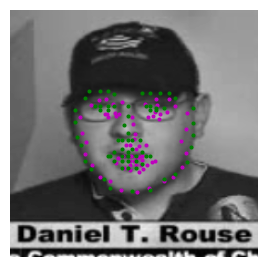

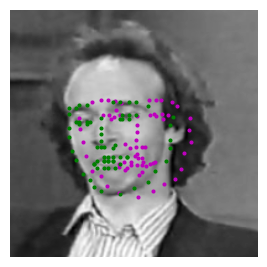

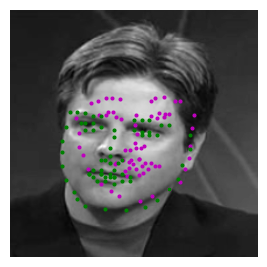

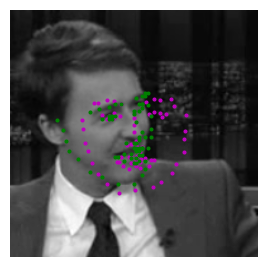

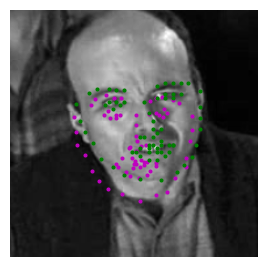

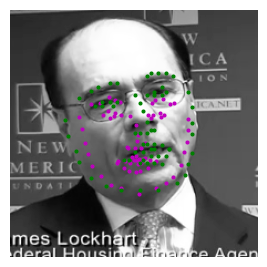

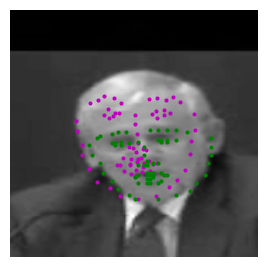

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_mine.pth'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: </br> I choosed  MSELoss for the loss funtions. Because, we are predicting the x and y numeric continous values for this homework. It is actually a regression problem. MSELoss commonly used for regression problems to calculating error between predicted and actual value. </br>
For the optimization, I used Adam optimizer first which adapts the learning rate for each parameter individually.  Also, It was suggested on the NaimishNet paper.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
</br>
Firstly, I looked at the suggested paper "Facial Key Points Detection using Deep Convolutional Neural Network - NaimishNet". This network was very deep and complicated for the start point. So, I started with the smaller version of it: </br>

Net(</br>
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))</br>
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))</br>
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (fc1): Linear(in_features=200704, out_features=136, bias=True)</br>
)</br>


I run this network for 1 epoch. Then I added 2 convolution and 1 fc layer to the network. After this change, there was no big change in loss value at the end of 1 epoch. I decided to get further. </br>

I tried a lot of cases, such as changing kernel sizes and adding dropouts. But, there was no big change at the end of the first batch loss. I thought maybe the network was not trained a lot. So, I selected the best structure, which is very similar to the NaimishNet as below:</br>

Net(</br>
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))</br>
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (drop1): Dropout(p=0.1, inplace=False)</br>
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))</br>
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (drop2): Dropout(p=0.2, inplace=False)</br>
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))</br>
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (drop3): Dropout(p=0.3, inplace=False)</br>
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))</br>
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (drop4): Dropout(p=0.4, inplace=False)</br>
  (fc1): Linear(in_features=57600, out_features=512, bias=True)</br>
  (drop5): Dropout(p=0.5, inplace=False)</br>
  (fc2): Linear(in_features=512, out_features=128, bias=True)</br>
  (fc3): Linear(in_features=128, out_features=136, bias=True)</br>
)</br>

However, the result of the this network was not good. the loss value was staying around the same number. The network was not learning, may be it was too simple. So, I decided to create NaimishNet as below:</br>

Net(</br>
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))</br>
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)</br>
  (drop1): Dropout(p=0.1, inplace=False)</br>
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))</br>
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)</br>
  (drop2): Dropout(p=0.2, inplace=False)</br>
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))</br>
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)</br>
  (drop3): Dropout(p=0.3, inplace=False)</br>
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))</br>
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)</br>
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)</br>
  (drop4): Dropout(p=0.4, inplace=False)</br>
  (fc1): Linear(in_features=43264, out_features=640, bias=True)</br>
  (bn5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)</br>
  (drop5): Dropout(p=0.5, inplace=False)</br>
  (fc2): Linear(in_features=640, out_features=768, bias=True)</br>
  (bn6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)</br>
  (drop6): Dropout(p=0.6, inplace=False)</br>
  (fc3): Linear(in_features=768, out_features=136, bias=True)</br>
)</br>

This network more deeper than mine. Also, as the paper suggested, I used Glorot uniform initializer for FC layers, relu function for activation and I added batch normalizations. It was the best network I tried.</br>


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:</br>
I tried 32 batch sizes during my test, but they affected the model worse. For the network I selected last, I used 16 batch sizes to get results quickly. </br>
I decided to use a high epoch number. Because the network has many layers, it has more parameters to learn. So I selected 40 epochs number. </br>

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.02343458 -0.00921159  0.02234488]
 [-0.00832685  0.01838911  0.01974344]
 [-0.01435678  0.02556957 -0.01111499]]
(3, 3)


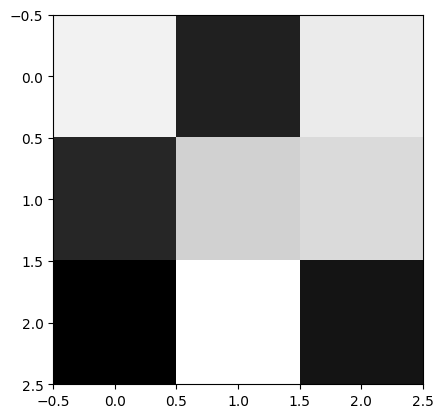

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv4.weight.data.cpu()

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

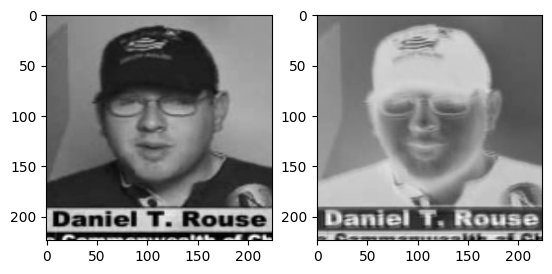

In [31]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

img= test_images[1].cpu().squeeze().numpy()

weights = net.conv1.weight.data.cpu()
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig,ax=plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
ax[1].imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:

I applied conv1 weights to several image. You can see an example of image in above. This filter detects the color change.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!